Import  libraries

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, GridSearchCV

Fetch 'flightdata.csv' dataset from the drive

In [2]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='B-mke6pQBw9kwg8nriXn9Ol5OxIc98g0JX0DClGPTqVc',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'flightdelay3-donotdelete-pr-5egm4atp9058zx'
object_key = 'flightdata.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

dataset = pd.read_csv(body)
dataset.head()


,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


Data visulazation and analysis

In [3]:
print(dataset.columns)
dataset.head()

Index(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
       'UNIQUE_CARRIER', 'TAIL_NUM', 'FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN',
       'DEST_AIRPORT_ID', 'DEST', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY',
       'DEP_DEL15', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DEL15',
       'CANCELLED', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME',
       'DISTANCE', 'Unnamed: 25'],
      dtype='object')


,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11231 entries, 0 to 11230
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 11231 non-null  int64  
 1   QUARTER              11231 non-null  int64  
 2   MONTH                11231 non-null  int64  
 3   DAY_OF_MONTH         11231 non-null  int64  
 4   DAY_OF_WEEK          11231 non-null  int64  
 5   UNIQUE_CARRIER       11231 non-null  object 
 6   TAIL_NUM             11231 non-null  object 
 7   FL_NUM               11231 non-null  int64  
 8   ORIGIN_AIRPORT_ID    11231 non-null  int64  
 9   ORIGIN               11231 non-null  object 
 10  DEST_AIRPORT_ID      11231 non-null  int64  
 11  DEST                 11231 non-null  object 
 12  CRS_DEP_TIME         11231 non-null  int64  
 13  DEP_TIME             11124 non-null  float64
 14  DEP_DELAY            11124 non-null  float64
 15  DEP_DEL15            11124 non-null 

In [5]:
dataset.describe()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_NUM,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,CRS_DEP_TIME,DEP_TIME,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
count,11231.0,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11124.000000,...,11231.000000,11116.000000,11043.000000,11043.000000,11231.000000,11231.000000,11231.000000,11043.000000,11231.000000,0.0
mean,2016.0,2.544475,6.628973,15.790758,3.960199,1334.325617,12334.516695,12302.274508,1320.798326,1327.189410,...,1537.312795,1523.978499,-2.573123,0.124513,0.010150,0.006589,190.652124,179.661233,1161.031965,NaN
std,0.0,1.090701,3.354678,8.782056,1.995257,811.875227,1595.026510,1601.988550,490.737845,500.306462,...,502.512494,512.536041,39.232521,0.330181,0.100241,0.080908,78.386317,77.940399,643.683379,NaN
min,2016.0,1.000000,1.000000,1.000000,1.000000,7.000000,10397.000000,10397.000000,10.000000,1.000000,...,2.000000,1.000000,-67.000000,0.000000,0.000000,0.000000,93.000000,75.000000,509.000000,NaN
25%,2016.0,2.000000,4.000000,8.000000,2.000000,624.000000,10397.000000,10397.000000,905.000000,905.000000,...,1130.000000,1135.000000,-19.000000,0.000000,0.000000,0.000000,127.000000,117.000000,594.000000,NaN
50%,2016.0,3.000000,7.000000,16.000000,4.000000,1267.000000,12478.000000,12478.000000,1320.000000,1324.000000,...,1559.000000,1547.000000,-10.000000,0.000000,0.000000,0.000000,159.000000,149.000000,907.000000,NaN
75%,2016.0,3.000000,9.000000,23.000000,6.000000,2032.000000,13487.000000,13487.000000,1735.000000,1739.000000,...,1952.000000,1945.000000,1.000000,0.000000,0.000000,0.000000,255.000000,236.000000,1927.000000,NaN
max,2016.0,4.000000,12.000000,31.000000,7.000000,2853.000000,14747.000000,14747.000000,2359.000000,2400.000000,...,2359.000000,2400.000000,615.000000,1.000000,1.000000,1.000000,397.000000,428.000000,2422.000000,NaN


Handling null values

In [6]:
#finding the number of null values present in each attributes
dataset.isnull().sum()

YEAR                       0
QUARTER                    0
MONTH                      0
DAY_OF_MONTH               0
DAY_OF_WEEK                0
UNIQUE_CARRIER             0
TAIL_NUM                   0
FL_NUM                     0
ORIGIN_AIRPORT_ID          0
ORIGIN                     0
DEST_AIRPORT_ID            0
DEST                       0
CRS_DEP_TIME               0
DEP_TIME                 107
DEP_DELAY                107
DEP_DEL15                107
CRS_ARR_TIME               0
ARR_TIME                 115
ARR_DELAY                188
ARR_DEL15                188
CANCELLED                  0
DIVERTED                   0
CRS_ELAPSED_TIME           0
ACTUAL_ELAPSED_TIME      188
DISTANCE                   0
Unnamed: 25            11231
dtype: int64

In [7]:
dataset['DEST'].unique()

array(['SEA', 'MSP', 'DTW', 'ATL', 'JFK'], dtype=object)

<AxesSubplot:xlabel='ARR_DELAY', ylabel='ARR_DEL15'>

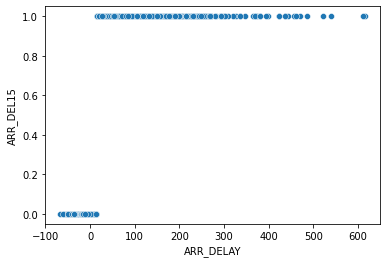

In [8]:
sns.scatterplot(x='ARR_DELAY',y='ARR_DEL15',data=dataset)

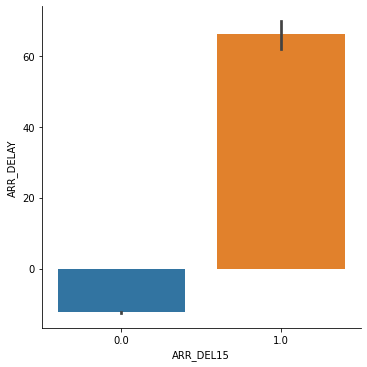

In [9]:
#catplot shows frequencies (or optionally fractions or percents) of the categories of one, two or three categorical variables
sns.catplot(x="ARR_DEL15",y="ARR_DELAY",kind='bar',data=dataset)

<AxesSubplot:>

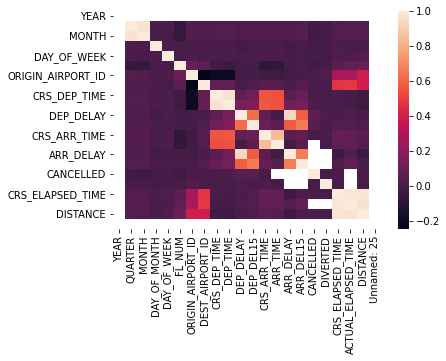

In [10]:
# 1. Correlation is a statistical relationship between two variables and it could be positive, meaning both variables move in the same direction, or negative, meaning that when one variable's value increases, the other variables' values decrease.
# 2. With the help of seaborn heatmap we will be plotting the heatmap and for finding the correlation between variables we have corr() available.
sns.heatmap(dataset.corr())

In [11]:
dataset=dataset[["FL_NUM","MONTH","DAY_OF_MONTH","DAY_OF_WEEK","ORIGIN","DEST","CRS_DEP_TIME","CRS_ARR_TIME","DEP_TIME","ARR_DEL15"]]
print(dataset.isnull().sum())

FL_NUM            0
MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
ORIGIN            0
DEST              0
CRS_DEP_TIME      0
CRS_ARR_TIME      0
DEP_TIME        107
ARR_DEL15       188
dtype: int64


Handling missing values in 'ARR_DEL15'

In [12]:
dataset=dataset.fillna({'ARR_DEL15':1})
# dataset=dataset.fillna(df['DEP_TIME'].median(), inplace=True)
dataset.iloc[177:185]

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,DEP_TIME,ARR_DEL15
177,2834,1,9,6,MSP,SEA,701,852,659.0,1.0
178,2839,1,9,6,DTW,JFK,1527,1724,1523.0,0.0
179,86,1,10,7,MSP,DTW,1348,1632,NaN,1.0
180,87,1,10,7,DTW,MSP,1540,1649,1604.0,0.0
181,423,1,10,7,JFK,ATL,1325,1600,1336.0,0.0
182,440,1,10,7,JFK,ATL,610,849,609.0,0.0
183,485,1,10,7,JFK,SEA,1615,1945,1720.0,0.0
184,557,1,10,7,MSP,DTW,625,912,620.0,1.0


ONE-HOT ENCODING on ORGIN and DEST features which has categorical values.

In [13]:
dataset = pd.get_dummies(dataset, columns=['ORIGIN', 'DEST'])
dataset.head()

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,CRS_ARR_TIME,DEP_TIME,ARR_DEL15,ORIGIN_ATL,ORIGIN_DTW,ORIGIN_JFK,ORIGIN_MSP,ORIGIN_SEA,DEST_ATL,DEST_DTW,DEST_JFK,DEST_MSP,DEST_SEA
0,1399,1,1,5,1905,2143,1907.0,0.0,1,0,0,0,0,0,0,0,0,1
1,1476,1,1,5,1345,1435,1344.0,0.0,0,1,0,0,0,0,0,0,1,0
2,1597,1,1,5,940,1215,942.0,0.0,1,0,0,0,0,0,0,0,0,1
3,1768,1,1,5,819,1335,820.0,0.0,0,0,0,0,1,0,0,0,1,0
4,1823,1,1,5,2300,607,2256.0,0.0,0,0,0,0,1,0,1,0,0,0


FEATURE IMPORTANCE by GINI IMPORTANCE TECHNIQUE.

<ipython-input-14-6f99f3e2da27>:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, Y_train)


[0.05534062 0.04560807 0.09593123 0.05340176 0.32868576 0.0749454
 0.29389233 0.00469394 0.00471711 0.00592308 0.0060604  0.00283251
 0.00572186 0.00481373 0.00520154 0.00577122 0.00645942]


Text(0.5, 0, 'Feature Importance')

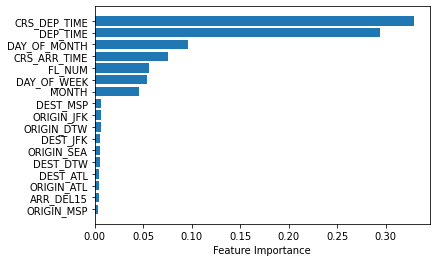

In [14]:
from sklearn.ensemble import RandomForestRegressor  
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
dataset.fillna(999, inplace=True)

df = pd.DataFrame(dataset)

X = df.drop(columns=['ARR_DEL15'])
Y = df[['ARR_DEL15']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rf = RandomForestRegressor(n_estimators=150)
rf.fit(X_train, Y_train)

sort = rf.feature_importances_.argsort()
print(rf.feature_importances_)
plt.barh(dataset.columns[sort], rf.feature_importances_[sort])
plt.xlabel("Feature Importance")


Random Forest Classifier

<ipython-input-16-a021911d9ade>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_reg.fit(X_train,Y_train)


Mean Absolute Error: 0.10648148148148148
Mean Squared Error: 0.10648148148148148
Root Mean Squared Error: 0.3263150034575203
Accuracy: 0.8935185185185185
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94      2421
         1.0       0.82      0.29      0.43       387

    accuracy                           0.89      2808
   macro avg       0.86      0.64      0.69      2808
weighted avg       0.89      0.89      0.87      2808

[[2396   25]
 [ 274  113]]


<AxesSubplot:>

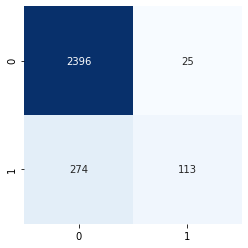

In [16]:
forest_reg = RandomForestClassifier(n_estimators = 10, criterion = 'entropy',random_state = 42)
forest_reg.fit(X_train,Y_train)
pred = forest_reg.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, pred)))
print("Accuracy:",metrics.accuracy_score(Y_test, pred))
#print("Report for test size = ", test_sz[i], "is shown below:")
print(classification_report(Y_test, pred))
matrix_confusion = confusion_matrix(y_true=Y_test, y_pred=pred)
print(matrix_confusion)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mean Absolute Error: 0.12927350427350429
Mean Squared Error: 0.12927350427350429
Root Mean Squared Error: 0.35954624775333743
Accuracy: 0.8707264957264957
              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93      2421
         1.0       1.00      0.06      0.12       387

    accuracy                           0.87      2808
   macro avg       0.93      0.53      0.52      2808
weighted avg       0.89      0.87      0.82      2808

[[2421    0]
 [ 363   24]]


<AxesSubplot:>

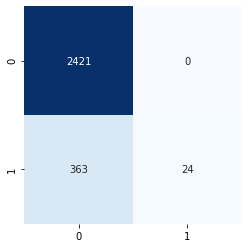

In [17]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, Y_train)
pred = clf.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, pred)))
print("Accuracy:",metrics.accuracy_score(Y_test, pred))
#print("Report for test size = ", test_sz[i], "is shown below:")
print(classification_report(Y_test, pred))
matrix_confusion = confusion_matrix(y_true=Y_test, y_pred=pred)
print(matrix_confusion)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

Hyper parameter tuning

In [18]:
parameters = { 'solver':['newton-cg', 'lbfgs', 'liblinear'],
             'C':[100, 10, 1.0, 0.1, 0.01],
             'penalty':['l2']}

In [20]:
tuned_model = GridSearchCV(LogisticRegression(max_iter=800), param_grid=parameters, verbose=2)
tuned_model.fit(X_train, Y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   2.7s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ),

[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   1.8s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   1.9s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   2.1s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   1.7s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   1.3s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   2.6s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   1.2s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.6s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   2.4s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.1s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.1s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.3s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.3s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   3.0s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   2.4s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   2.3s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   2.7s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   2.5s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   2.1s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   2.2s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   2.2s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   2.1s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   1.1s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.3s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.3s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.1s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.3s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.2s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV] END ................C=1.0, penalty=l2, solver=newton-cg; total time=   2.3s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ................C=1.0, penalty=l2, solver=newton-cg; total time=   1.9s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchW

[CV] END ................C=1.0, penalty=l2, solver=newton-cg; total time=   2.4s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ................C=1.0, penalty=l2, solver=newton-cg; total time=   1.9s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV] END ................C=1.0, penalty=l2, solver=newton-cg; total time=   2.6s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ....................C=1.0, penalty=l2, solver=lbfgs; total time=   2.2s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] END ....................C=1.0, penalty=l2, solver=lbfgs; total time=   2.8s
[CV] END ....................C=1.0, penalty=l2, solver=lbfgs; total time=   1.4s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] END ....................C=1.0, penalty=l2, solver=lbfgs; total time=   2.0s
[CV] END ....................C=1.0, penalty=l2, solver=lbfgs; total time=   1.9s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ................C=1.0, penalty=l2, solver=liblinear; total time=   0.2s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ................C=1.0, penalty=l2, solver=liblinear; total time=   0.3s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ................C=1.0, penalty=l2, solver=liblinear; total time=   0.3s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ................C=1.0, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ................C=1.0, penalty=l2, solver=liblinear; total time=   0.1s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   2.7s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   1.9s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   1.7s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   2.1s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   2.0s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.9s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   1.7s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.5s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   2.1s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   1.6s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.1s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.3s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.2s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.2s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   2.1s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\v

[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   2.4s
[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   1.9s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   1.9s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   1.7s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   5.5s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   3.6s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   2.7s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   2.7s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   2.1s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.1s

c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.1s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.2s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.1s


c:\Users\ELCOT\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GridSearchCV(estimator=LogisticRegression(max_iter=800),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             verbose=2)

testing the tuned model

In [21]:
Y_pred_tun_train = tuned_model.predict(X_train)
Y_pred_tun_test = tuned_model.predict(X_test)

In [22]:
pd.DataFrame(Y_pred_tun_train).value_counts()

0.0    8371
1.0      52
dtype: int64

In [29]:
pd.DataFrame(Y_pred_tun_test).value_counts()

0.0    2783
1.0      25
dtype: int64

Evaluate the tuned model using metrics

In [28]:
print(classification_report(Y_test, Y_pred_tun_test))

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93      2421
         1.0       1.00      0.06      0.12       387

    accuracy                           0.87      2808
   macro avg       0.93      0.53      0.53      2808
weighted avg       0.89      0.87      0.82      2808



precisoin, recall, f1-score

In [30]:
acc_tun = accuracy_score(Y_test, Y_pred_tun_test)
prec_tun, rec_tun, f1_tun, sup_tun = precision_recall_fscore_support(Y_test, Y_pred_tun_test)
print('Accuracy Score =', acc_tun)
print('Precision =', prec_tun[0])
print('Recall =', rec_tun[0])
print('F1 Score =', f1_tun[0])

Accuracy Score = 0.8710826210826211
Precision = 0.8699245418613007
Recall = 1.0
F1 Score = 0.9304381245196003


checking for overfitting and underfitting

In [31]:
tun_train_acc = accuracy_score(Y_train, Y_pred_tun_train)
tun_test_acc = accuracy_score(Y_test, Y_pred_tun_test)
print('Training Accuracy =', tun_train_acc)
print('Testing Accuracy =', tun_test_acc)

Training Accuracy = 0.866555858957616
Testing Accuracy = 0.8710826210826211


confusion matrix

dumb the model

since the accuracy for logistic regression and hyper parameter tuning is less than the random forest classifier we use random forest classifier

In [36]:
joblib.dump(forest_reg, 'model_forest_reg.pkl')

['model_forest_reg.pkl']

In [1]:
!pip install -U ibm-watson-machine-learning

from ibm_watson_machine_learning import APIClient
import json

wml_credentials = {
    "apikey":"dOwmdbcncwb3HcJuEMKQH7AHy66viTvlYB31FoRQnmzm",
    "url":"https://us-south.ml.cloud.ibm.com"
}

wml_client = APIClient(wml_credentials)

In [46]:
wml_client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  ------------------  ------------------------
ID                                    NAME                CREATED
c8b1f6ea-f47f-4613-ab3d-abddf409c842  fight_delay_2       2022-11-19T08:39:06.268Z
6e3191c7-b6e0-4c95-aaf7-bb044ec893a6  flightdelay_deploy  2022-11-19T06:17:23.803Z
------------------------------------  ------------------  ------------------------


In [49]:
SPACE_ID = "c8b1f6ea-f47f-4613-ab3d-abddf409c842"

In [51]:
wml_client.set.default_space(SPACE_ID)

wml_client.software_specifications.list(500)

import sklearn
sklearn.__version__

MODEL_NAME = 'flight-delay'
DEPLOYMENT_NAME = 'flight-delay'
DEMO_MODEL = forest_reg

software_spec_uid = wml_client.software_specifications.get_id_by_name('runtime-22.1-py3.9')

model_props = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME, 
    wml_client.repository.ModelMetaNames.TYPE: 'scikit-learn_1.0', 
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid 
}

model_details = wml_client.repository.store_model(
    model=DEMO_MODEL, 
    meta_props=model_props, 
    training_data=X_train, 
    training_target=Y_train
)

print(model_details)

model_id = wml_client.repository.get_model_id(model_details)
print(model_id)

deployment_props = {
    wml_client.deployments.ConfigurationMetaNames.NAME:DEPLOYMENT_NAME, 
    wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
}

deployment = wml_client.deployments.create(
    artifact_uid=model_id,
    meta_props=deployment_props
)



-------------------------------  ------------------------------------  ----
NAME                             ASSET_ID                              TYPE
default_py3.6                    0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12        020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt       069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6          09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12       09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9        0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6            0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                       0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod     1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6                10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl        111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt



#######################################################################################

Synchronous deployment creation for uid: 'e00b91ee-77ef-4611-a1e6-51de3380f26c' started

#######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.

ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='4d3b06b1-4fe8-4775-bc6c-f85e8544e21f'
------------------------------------------------------------------------------------------------


